# Topological feature for lung tumor type classification (SF/PA cohort)

In this notebook, we will study the use of topological features for lungg tumor type classification. We start by setting the working directory and importing the required libraries.

In [ ]:
# Set working directory (change accordingly)
workdir = "/home/robin/Documents/Stanford_VSR/NMI/Code"

import os
import sys
os.chdir("/home/robin/Documents/Stanford_VSR/NMI/Code")
sys.path.insert(0, os.path.join(workdir, "Functions"))

In [ ]:
# Topological feature extraction
import TDAfeatures as tf

# Handling arrays and data frames
import numpy as np


In [1]:
import importlib # for reloading libraries if needed
import TDAfeatures as tf # functions for extracting topological features from 3D images
importlib.reload(tf) # reload
import experiments_functions # # contains functions to conduct our feature comparison experiments
importlib.reload(experiments_functions) # reload
from experiments_functions import run_exps, mrmrSelector # function to conduct our feature evaluation experiments 
import os # os independent path construction 
import time # track computation time
import numpy as np # handling arrays and general math
import matplotlib.pyplot as plt # plotting
import pandas as pd # working with data frames
from ripser import ripser # persistent homology of metric spaces
from persim import plot_diagrams # plotting persistence diagrams
from mpl_toolkits.mplot3d import Axes3D # 3d plotting of image pixels
import plotly # 3d plotting of tumors
import plotly.graph_objs as go # 3d plotting configuration
from mpl_toolkits.mplot3d.art3d import Poly3DCollection # plotting meshes
import scipy # conducting t-test
from sklearn.impute import SimpleImputer # for imputing missing values
from sklearn.preprocessing import MinMaxScaler # preprocessing features
from sklearn.linear_model import LogisticRegression # linear regression based classification model
from sklearn.svm import SVC # support vector machine model
from sklearn.pipeline import make_pipeline # make pipeline combining preprocessing and ML models
import gudhi # compute bottleneck distances
from sklearn.manifold import MDS # MDS plot (of bottleneck distances)

## Computing the Persistence Diagrams from Images

We illustrate our procedure through an example lesion.

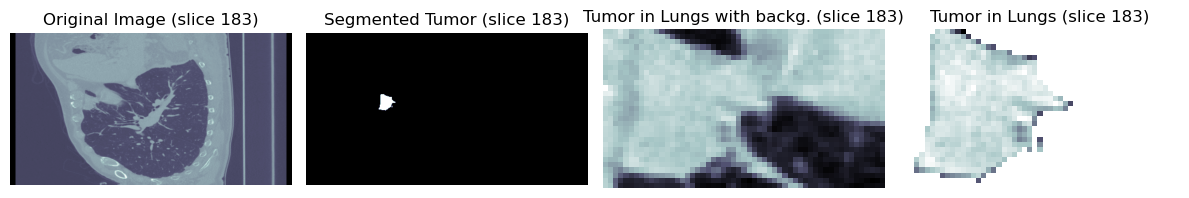

In [23]:
patient_idx = 138
patient_prefix = "SF"
patient = patient_prefix + "_" + str(patient_idx).zfill(3)
img_path_local = os.path.join("image", patient + ".nii.gz")
mask_path_local = os.path.join("mask", patient + ".nii.gz")

# extract the radiology image
lungs_img = tf.np_from_sitk(tf.read_nifti(img_path_local)) 

# extract the segmented tumor
lesion_mask = tf.np_from_sitk(tf.read_nifti(mask_path_local))

# extract the tumor pixels from the radiology images
lesion_img_box = tf.segment_3Darray(lesion_mask, lungs_img, fillnan=False)
lesion_img = tf.segment_3Darray(lesion_mask, lungs_img)

current_tumor_pixels = -1
for idx in range(lesion_mask.shape[2]):
    tumor_pixels_at_idx = np.sum(lesion_mask[:,:,idx] == 1)
    if tumor_pixels_at_idx > current_tumor_pixels:
        current_tumor_pixels = tumor_pixels_at_idx
        tumor_idx = idx

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
ax = axes.flatten()

ax[0].imshow(lungs_img[:,:,tumor_idx], cmap=plt.cm.bone)
ax[0].set_axis_off()
ax[0].set_title("Original Image (slice " + str(tumor_idx) + ")", fontsize=12)

ax[1].imshow(lesion_mask[:,:,tumor_idx], cmap=plt.cm.bone)
ax[1].set_axis_off()
ax[1].set_title("Segmented Tumor (slice " + str(tumor_idx) + ")", fontsize=12)

ax[2].imshow(lesion_img_box[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[2].set_axis_off()
ax[2].set_title("Tumor in Lungs with backg. (slice " + str(tumor_idx) + ")", fontsize=12)

ax[3].imshow(lesion_img[:,:,tumor_idx - tf.bbox_3D(lesion_mask)[4]], cmap=plt.cm.bone)
ax[3].set_axis_off()
ax[3].set_title("Tumor in Lungs (slice " + str(tumor_idx) + ")", fontsize=12)

fig.tight_layout()
plt.show()

Before proceeding, we first visualize how a filtration is constructed from the image of a tumor.

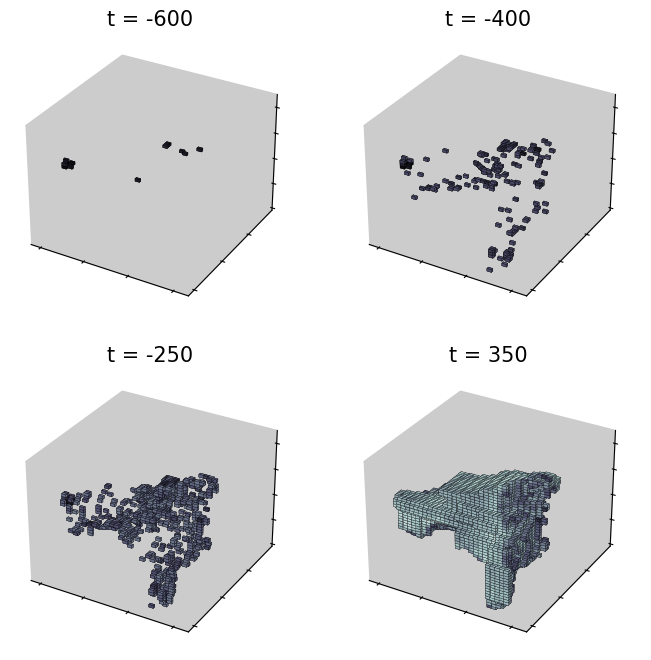

In [24]:
ts = [-600, -400, -250, 350]

not_filled = np.ones_like(lesion_img)
filled = np.zeros_like(lesion_img)
colors = plt.cm.bone((lesion_img - np.nanmin(lesion_img))  / (np.nanmax(lesion_img) - np.nanmin(lesion_img)))

fig = plt.figure(figsize=(8, 8))

for idx, t in enumerate(ts):
    to_fill = lesion_img <= t
    filled[to_fill] = 1
    not_filled[to_fill] = 0
    
    ax = fig.add_subplot(2, 2, idx +  1, projection="3d")
    ax.grid(False)
    ax.voxels(filled, facecolors=colors, edgecolors="black", shade=False, linewidth=0.2)
    
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    
    plt.gca().patch.set_facecolor("white")
    ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
    ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
    ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
    
    ax.set_title("t = {}".format(t), fontsize=15)

plt.show()

We can now compute persistent homology of the tumor image pixels as follows.

Time for computing persistence: 00:00:04


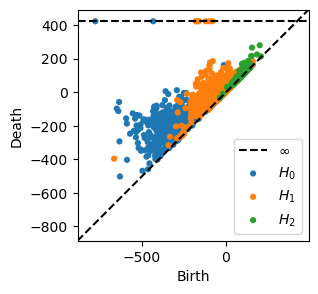

In [54]:
start_time = time.time()
dgms_img = tf.lower_star_img3D(lesion_img)
elapsed_time = time.time() - start_time
print("Time for computing persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

plt.figure(figsize=(3, 3))
plot_diagrams(dgms_img)
plt.show()

We can also take into account the pixels in the bounding box of the image when computing persistent homology. 

Time for computing persistence: 00:00:04


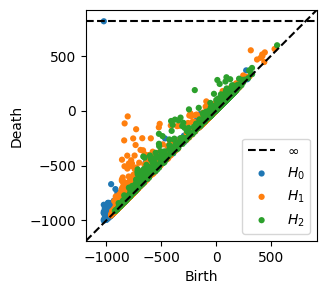

In [147]:
start_time = time.time()
dgms_box = tf.lower_star_img3D(lesion_img_box)
elapsed_time = time.time() - start_time
print("Time for computing persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

plt.figure(figsize=(3, 3))
plot_diagrams(dgms_box)
plt.show()

The diagrams for each lesion are computed on the Stanford Nero Computing server.

## Computing the Extended Persistence Diagrams from Images

The following function allows to compute extended persistence, which guarantees finite death-times.

Time for computing extended persistence: 00:00:08


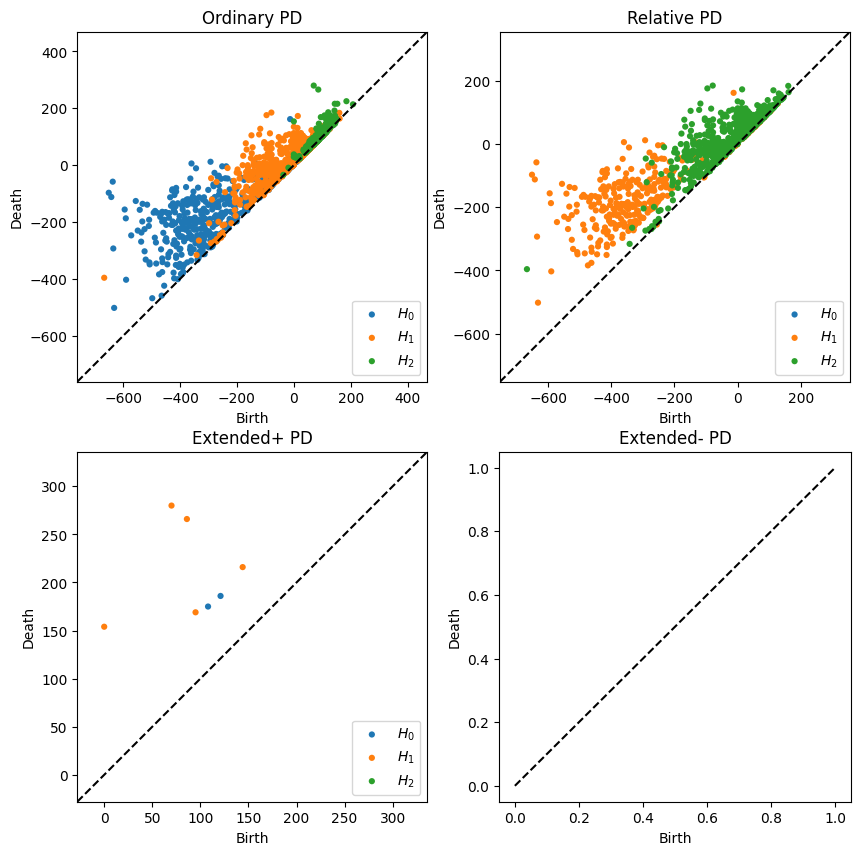

In [8]:
start_time = time.time()
dgms_extended_img = tf.lower_star_img3D_extended(lesion_img)
elapsed_time = time.time() - start_time
print("Time for computing extended persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

tf.plot_extended_diagrams(dgms_extended_img)

As before, we can also compute extended persistence when taking into account the pixels in the bounding box of the image.

Time for computing extended persistence: 00:00:21


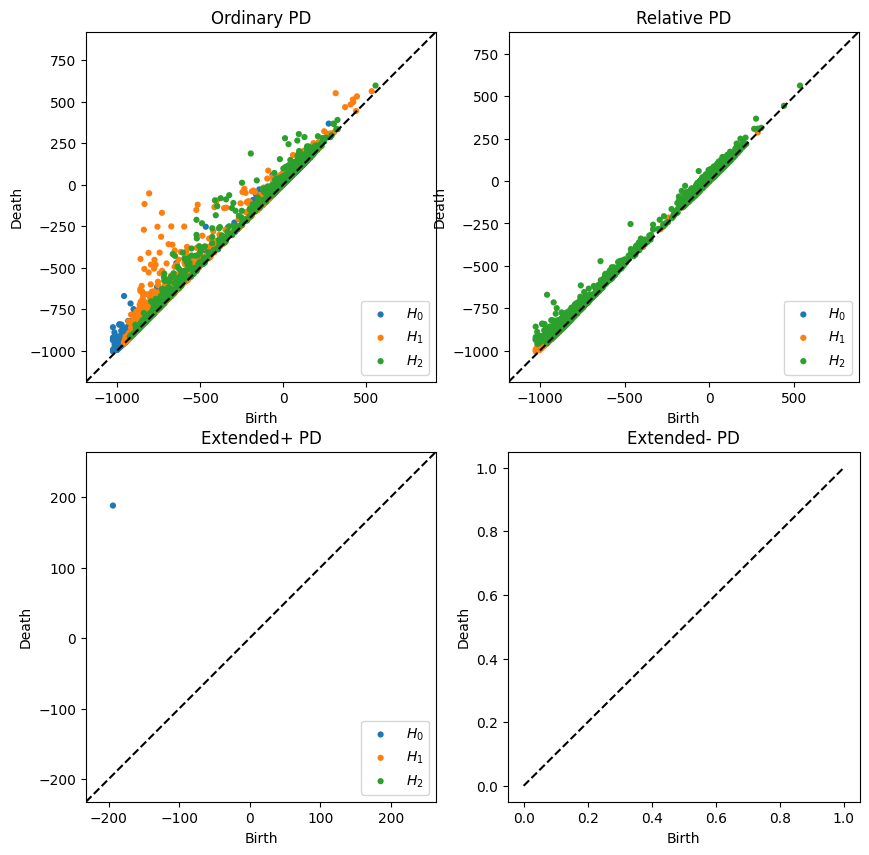

In [7]:
start_time = time.time()
dgms_extended_img_box = tf.lower_star_img3D_extended(lesion_img_box)
elapsed_time = time.time() - start_time
print("Time for computing extended persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

tf.plot_extended_diagrams(dgms_extended_img_box)

The extended diagrams for each lesion are computed on the Stanford Nero Computing server.

## Computing the Persistence Diagrams from Point Clouds

We define a point cloud from the boundary pixels of the lesion.

In [3]:
vol = tf.read_nifti(img_path_local)
verts = tf.point_cloud_from_lesion(vol, lesion_mask)
print("Number of points on surface: " + str(verts.shape[0]))

# configure Plotly to be rendered inline in the notebook
plotly.offline.init_notebook_mode()

# configure the trace
trace = go.Scatter3d(
    x = verts[:,0],
    y = verts[:,1],
    z = verts[:,2],
    mode = "markers",
    marker={
        "size": .5,
        "opacity": 0.8,
    }
)

# configure the layout
layout = go.Layout(
    margin={"l": 0, "r": 0, "b": 0, "t": 0},
    width = 300,
    height = 300
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

Number of points on surface: 6128


The point clouds generally too large for computing 2-dimensional persistent homology. We can overcome this issue by using a theoretically justified approximation algorithm for computing our diagrams. The simplicial complex is constructed on a set of landmarks in stead. However, this itroduces some randomness and an additional hyperparameter.

Time for computing persistence: 00:00:18


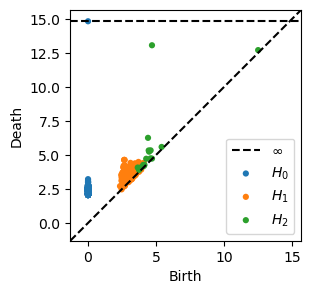

In [11]:
n_landmarks = 500

start_time = time.time()
dgms = ripser(verts, maxdim=2, n_perm=n_landmarks)["dgms"]
elapsed_time = time.time() - start_time
print("Time for computing persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

plt.figure(figsize=(3, 3))
plot_diagrams(dgms)
plt.show()

The persistence diagram for each tumor are approximated on the Stanford Nero Computing Server.

## Topological Features from Meshes

A first possible approach for meshes is through the exact same procedure for for point clouds. Instead, we use the metric defined by the mesh in stead of the euclidean distances between the points for defining the filtration. We illustrate our procedure through an example lesion.

Number of vertices on surface: 6128


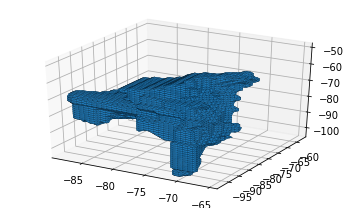

In [97]:
verts, faces = tf.mesh_from_lesion(vol, lesion_mask)
print("Number of vertices on surface: " + str(verts.shape[0]))

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces], linewidths=.1)
mesh.set_edgecolor("k")
ax.add_collection3d(mesh)
plt.tight_layout()
plt.show()

We can compute the geodesic distances defined by the mesh faces as follows.

In [183]:
start_time = time.time()
geoD = tf.geodesic_distances(verts, faces)
elapsed_time = time.time() - start_time
print("Time for computing geodesic distances: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Time for computing geodesic distances: 00:00:15


We can approximate persistent homology computation for arbitrary distance matrices as follows. 

Time for computing persistence: 00:00:29


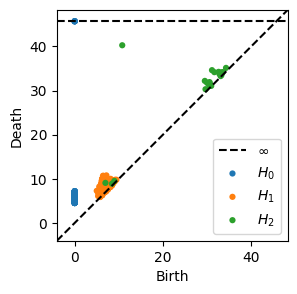

In [11]:
n_landmarks = 500

start_time = time.time()
dgms = ripser(geoD, maxdim=2, distance_matrix=True, n_perm=n_landmarks)["dgms"]
elapsed_time = time.time() - start_time
print("Time for computing persistence: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

plt.figure(figsize=(3, 3))
plot_diagrams(dgms)
plt.show()

## Loading the data and defining the problem

We start by loading the persistence diagrams for all patients.

In [25]:
dgms = {"img_sub":{}, "img_sup":{}, "img_box_sub":{}, "img_box_sup":{}, "point_cloud":{}, "mesh":{}}

for patient in os.listdir("diagram"):
    for dgm in os.listdir(os.path.join("diagram", patient)):
        
        dgmtype = "_".join(dgm.split("_")[:-1])
        dgmdim = dgm.split("_")[-1].replace(".npy", "")
        dgms[dgmtype].setdefault(patient, {})
        dgms[dgmtype][patient][dgmdim] = np.load(os.path.join("diagram", patient, dgm))

patients = os.listdir("diagram")  
missing = {}
missing["img_sub"] = [p for p in patients if p not in dgms["img_sub"].keys()]
missing["img_sup"] = [p for p in patients if p not in dgms["img_sup"].keys()]
missing["img_box_sub"] = [p for p in patients if p not in dgms["img_box_sub"].keys()]
missing["img_box_sup"] = [p for p in patients if p not in dgms["img_box_sup"].keys()]
missing["point_cloud"] = [p for p in patients if p not in dgms["point_cloud"].keys()]
missing["mesh"] = [p for p in patients if p not in dgms["mesh"].keys()]
   
print("No. of patients: " + str(len(patients)))
print("No. of patients without img sublevel filtration diagrams: " + str(len(missing["img_sub"])))
print("No. of patients without img superlevel filtration diagrams: " + str(len(missing["img_sup"])))
print("No. of patients without img box sublevel filtration diagrams: " + str(len(missing["img_box_sub"])))
print("No. of patients without img box superlevel filtration diagrams: " + str(len(missing["img_box_sup"])))
print("No. of patients without point cloud diagrams: " + str(len(missing["point_cloud"])))
print("No. of patients without mesh diagrams: " + str(len(missing["mesh"])))

No. of patients: 192
No. of patients without img sublevel filtration diagrams: 3
No. of patients without img superlevel filtration diagrams: 3
No. of patients without img box sublevel filtration diagrams: 2
No. of patients without img box superlevel filtration diagrams: 2
No. of patients without point cloud diagrams: 1
No. of patients without mesh diagrams: 133


We load the meta data for all patients for which we have available persistence diagrams.

In [26]:
dgm_types = {"img_sub":["dgm0", "dgm1", "dgm2"], 
             "img_sup":["dgm0", "dgm1", "dgm2"], 
             "img_box_sub":["dgm0", "dgm1", "dgm2"], 
             "img_box_sup":["dgm0", "dgm1", "dgm2"],
             "point_cloud":["dgm0", "dgm1", "dgm2"],
             "mesh":[]}

patients = os.listdir("diagram")
for dgm_type in dgm_types.keys():
    if len(dgm_types[dgm_type]) > 0:
        patients = np.setdiff1d(patients, missing[dgm_type])

meta = pd.read_excel("Diagnosis Key v9-2020.xlsx", index_col=0)
patients = np.intersect1d(patients, meta.index)

meta = meta.loc[patients, :]
meta["Diagnosis"] = [c.replace("\xa0", "") for c in meta["Diagnosis"]]
print("No. of patients in data: " + str(meta.shape[0]))
meta.head(5)

No. of patients in data: 188


Diagnosis Contrast Age Exact  Age in Years Sex Kernel Type  \
Patient                                                              
PA_001     Benign        N    75Y 1M          75.0   M         NaN   
PA_002     Benign        N   65Y 10M          65.0   M         NaN   
PA_003     Benign        N    83Y 9M          83.0   M         NaN   
PA_004     Benign        N    95Y 4M          95.0   M         NaN   
PA_006     Benign        N   69Y 11M          69.0   M         NaN   

         Slice Thickness  kVp  
Patient                        
PA_001               NaN  NaN  
PA_002               NaN  NaN  
PA_003               NaN  NaN  
PA_004               NaN  NaN  
PA_006               NaN  NaN

We also load the pregiven radiomics features for the patients.

In [27]:
X_radiomics = pd.concat([pd.read_csv(os.path.join("Features", "PA_lung_big_features.csv")),
                         pd.read_csv(os.path.join("Features", "SF_lung_big_features.csv"))])
X_radiomics_index = ["_".join(fpath.split("/")[-1].split("_")[:2]) for fpath in X_radiomics["Image"]]
X_radiomics["Patient"] = X_radiomics_index
X_radiomics = X_radiomics.set_index("Patient")
feature_columns = [c for c in X_radiomics.columns if c.startswith("original")]
X_radiomics =  X_radiomics.loc[patients, feature_columns]
X_radiomics.head(5)

original_shape_Elongation  original_shape_Flatness  \
Patient                                                       
PA_001                    0.610770                 0.447081   
PA_002                    0.635731                 0.580285   
PA_003                    0.916571                 0.734749   
PA_004                    0.133874                 0.119661   
PA_006                    0.735025                 0.622927   

         original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
Patient                                                                   
PA_001                        17.459217                       39.051593   
PA_002                         5.966781                       10.282491   
PA_003                        21.577785                       29.367550   
PA_004                         9.028164                       75.447635   
PA_006                         6.005287                        9.640430   

         original_shape_Maximum2DDiameterColumn  \
Patient                                           
PA_001                                46.529560   
PA_002                                10.630146   
PA_003                                34.003676   
PA_004                                65.122961   
PA_006                                11.045361   

         original_shape_Maximum2DDiameterRow  \
Patient                                        
PA_001                             30.516389   
PA_002                             10.816654   
PA_003                             35.805028   
PA_004                             66.098411   
PA_006                              9.178780   

         original_shape_Maximum2DDiameterSlice  \
Patient                                          
PA_001                               48.541220   
PA_002                                9.962429   
PA_003                               33.615473   
PA_004                               14.577380   
PA_006                               11.101802   

         original_shape_Maximum3DDiameter  original_shape_MeshVolume  \
Patient                                                                
PA_001                          51.546096                5701.083333   
PA_002                          12.449900                 245.968750   
PA_003                          37.848382               12003.239583   
PA_004                          66.115429                1860.093750   
PA_006                          11.324752                 209.031250   

         original_shape_MinorAxisLength  ...  \
Patient                                  ...   
PA_001                        23.851526  ...   
PA_002                         6.536897  ...   
PA_003                        26.917459  ...   
PA_004                        10.100467  ...   
PA_006                         7.085953  ...   

         original_glszm_LargeAreaLowGrayLevelEmphasis  \
Patient                                                 
PA_001                                       0.004885   
PA_002                                       0.005609   
PA_003                                       1.526580   
PA_004                                       0.003904   
PA_006                                       0.003931   

         original_glszm_LowGrayLevelZoneEmphasis  \
Patient                                            
PA_001                                  0.000569   
PA_002                                  0.002775   
PA_003                                  0.000307   
PA_004                                  0.001417   
PA_006                                  0.003019   

         original_glszm_SizeZoneNonUniformity  \
Patient                                         
PA_001                            6604.881271   
PA_002                             315.666667   
PA_003                            6184.995772   
PA_004                            3157.218097   
PA_006                             423.882166   

         original_glszm_SizeZoneNonUniformit

Finally, we may define a binary outcome variable based on the type of tumor. We first check which types are possible, and print their counts. 

In [28]:
all_classes = np.asarray(np.unique(meta["Diagnosis"], return_counts=True)).T
print(all_classes)
all_classes = [c[0] for c in all_classes]

[['Adenocarcinoma' 36]
 ['Benign' 98]
 ['Non-small cell lung cancer' 2]
 ['Small cell lung cancer' 31]
 ['Squamous cell carcinoma' 21]]


A binary outcome may now be obtained as follows.

Class distribution for current outcome (class0 = ['Benign'], class1 = ['Adenocarcinoma', 'Non-small cell lung cancer', 'Small cell lung cancer', 'Squamous cell carcinoma'])


<AxesSubplot:>

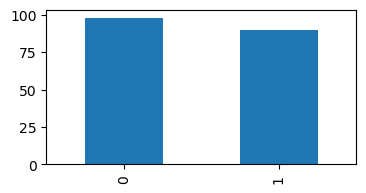

In [29]:
def get_patients_with_outcome(I, class0, class1):
    
    new_I = [patient for patient in I if meta.loc[patient, "Diagnosis"] in class0 + class1]
    y = np.array([0 if meta.loc[patient, "Diagnosis"] in class0 else 1 for patient in new_I]).astype("int")
    return new_I, y

class0 = ["Benign"]
class1 = [c for c in all_classes if c not in class0]
I, y = get_patients_with_outcome(meta.index, class0, class1)

print("Class distribution for current outcome (class0 = {}, class1 = {})".format(class0, class1))
pd.DataFrame(y).iloc[:,0].value_counts().sort_index().plot(kind="bar", figsize=(4, 2))

## Bivariate analysis of features and outcome

We start by extracting our topological features from the diagrams.

In [30]:
# compute topological features

X_top = pd.DataFrame()

for dgm_type in dgm_types:
    for dim in dgm_types[dgm_type]:
        these_features = list()
        for patient in meta.index:
            these_features.append(tf.persistence_statistics(dgms[dgm_type][patient][dim]))
            
        these_features = pd.DataFrame(these_features)
        these_features.index = meta.index
        these_features = these_features.rename(columns={column: dgm_type + "_" + dim + "_" + column \
                                                        for column in these_features.columns})
        
        X_top = pd.concat([X_top, these_features], axis=1)
        del these_features
        
# Delete the columns with constant values
non_constant_features = X_top.columns[np.where((X_top != X_top.iloc[0]).any())]
constant_features = np.setdiff1d(X_top.columns, non_constant_features)
X_top = X_top.loc[:,non_constant_features]
print("Discarded features (with constant values):")
print("\n")
for f in constant_features:
    print(f)
print("\n")

# check the dimensions of the resulting feature matrix

print(str(X_top.shape[1]) + " Topological features for " + str(X_top.shape[0]) + " patients remaining")

Discarded features (with constant values):


img_box_sub_dgm0_no_infinite_lifespans
img_box_sub_dgm1_no_infinite_lifespans
img_box_sub_dgm2_no_infinite_lifespans
img_box_sup_dgm0_no_infinite_lifespans
img_box_sup_dgm1_no_infinite_lifespans
img_box_sup_dgm2_no_infinite_lifespans
point_cloud_dgm0_min_birth
point_cloud_dgm0_no_infinite_lifespans
point_cloud_dgm1_no_infinite_lifespans
point_cloud_dgm2_no_infinite_lifespans


290 Topological features for 188 patients remaining


We now check if there are any significant differences between the topological features for a particular outcome.

In [388]:
contains_na = X_top.isna().any()
cols_to_drop = contains_na[contains_na == True].index

class0 = ["Benign"]
class1 = [c for c in all_classes if c not in class0]
I, y = get_patients_with_outcome(meta.index, class0, class1)

alpha = 0.05
topological_significant = list()
topological_ttests = scipy.stats.ttest_ind(X_top.drop(cols_to_drop, axis=1).iloc[np.where(y == 0)[0],:],
                                           X_top.drop(cols_to_drop, axis=1).iloc[np.where(y == 1)[0],:],
                                           equal_var=False)[1]
argsort_ttests = np.argsort(topological_ttests)

for idx in argsort_ttests:
    if topological_ttests[idx] <= alpha:
        topological_significant.append(X_top.columns[idx])
        
print(str(len(topological_significant)) + " out of " + str(len(topological_ttests)) + 
      " (~" + str(round(100 * len(topological_significant) / len(topological_ttests), 3)) + 
      "%) features with no missing values found to significantly differ for alpha = 0.05\n")

print_values = False
if print_values:
    print("\033[1mp-values t-tests for topological features by contrast")
    for idx in argsort_ttests:
        if topological_ttests[idx] <= alpha:
            print ("\033[1m" + X_top.columns[idx] + ": " + str(topological_ttests[idx]) + " \033[0m")
        else:
            print (X_top.columns[idx] + ": " + str(topological_ttests[idx]))

170 out of 245 (~69.388%) features with no missing values found to significantly differ for alpha = 0.05



We also check if there are any significant differences between the radiomics features for the particular outcome.

In [389]:
alpha = 0.05
radiomics_significant = list()
radiomics_ttests = scipy.stats.ttest_ind(X_radiomics.iloc[np.where(y == 0)[0],:],
                                         X_radiomics.iloc[np.where(y == 1)[0],:],
                                         equal_var=False)[1]
argsort_ttests = np.argsort(radiomics_ttests)

for idx in argsort_ttests:
    if radiomics_ttests[idx] <= alpha:
        radiomics_significant.append(X_radiomics.columns[idx])
        
print(str(len(radiomics_significant)) + " out of " + str(len(radiomics_ttests)) + 
      " (~" + str(round(100 * len(radiomics_significant) / len(radiomics_ttests), 3)) + 
      "%) features found to significantly differ for alpha = 0.05\n")

print_values = False
if print_values:
    print("\033[1mp-values t-tests for radiomics features by contrast")
    for idx in argsort_ttests:
        if radiomics_ttests[idx] <= alpha:
            print ("\033[1m" + X_radiomics.columns[idx] + ": " + str(radiomics_ttests[idx]) + " \033[0m")
        else:
            print (X_radiomics.columns[idx] + ": " + str(radiomics_ttests[idx]))

58 out of 88 (~65.909%) features found to significantly differ for alpha = 0.05



## Comparing features

We compare the effectivess of topological features, radiomics features, and topological + radiomics (through concatenation or ensembles) for binary tumor class prediction.

### Images with contrast

We first construct the feature DataFrames for performance evaluation on the images **with contrast**. 

In [74]:
contrast = ["Y"]
contrast_indices = [p for p in meta.index if meta.loc[p, "Contrast"] in contrast]

X_dict = {}

X_dict["rad"] = X_radiomics.copy().loc[contrast_indices,:]
X_dict["top"] = X_top.copy().loc[contrast_indices,:]
#for dgm_type in np.unique([k[:k.find("dgm") - 1] for k in X_top.columns]):
#for dgm_type in np.unique([k[:k.find("dgm") + 4] for k in X_top.columns]):
#    this_columns = [C for C in X_top.columns if C.startswith(dgm_type)]
#    X_dict[dgm_type] = X_top.copy().loc[contrast_indices, this_columns]

print("Number of patients with contrast {}: {}".format(contrast, str(len(contrast_indices))))

Number of patients with contrast ['Y']: 63


We evaluate the various features for **'benign'** vs. **'non-benign'** class prediction.

Class distribution for current outcome (class0 = ['Benign'], class1 = ['Adenocarcinoma', 'Non-small cell lung cancer', 'Small cell lung cancer', 'Squamous cell carcinoma'])
0    23
1    40
Name: 0, dtype: int64


<AxesSubplot:>

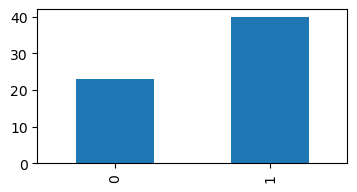

In [76]:
class0 = ["Benign"]
class1 = [c for c in all_classes if c not in class0]
I, y = get_patients_with_outcome(contrast_indices, class0, class1)

print("Class distribution for current outcome (class0 = {}, class1 = {})".format(class0, class1))
value_counts = pd.DataFrame(y).iloc[:,0].value_counts().sort_index()
print(value_counts)
value_counts.plot(kind="bar", figsize=(4, 2))

In [392]:
results_summary = run_exps(X_dict={key:X_dict[key].loc[I,] for key in X_dict.keys()}, y=y, random_state=42)

results_summary.loc["mean",:] = results_summary.mean()
print("Performance for tumor class prediction (class0 = {}, class1 = {})".format(class0, class1))
results_summary.style.highlight_max(color="lightgreen", axis=1)

Calculating performances for model: LogReg
Calculating performances for model: RF
Calculating performances for model: KNN
Calculating performances for model: SVM
Calculating performances for model: GNB
Calculating performances for model: XGB
Performance for tumor class prediction (class0 = ['Benign'], class1 = ['Adenocarcinoma', 'Non-small cell lung cancer', 'Small cell lung cancer', 'Squamous cell carcinoma'])


We investigate the feature importance for a better performing model.

Radiomic feature coefficients 
Feature: original_glcm_SumSquares, Coeff: 1.47
Feature: original_shape_Maximum2DDiameterRow, Coeff: 0.66
Feature: original_glrlm_RunEntropy, Coeff: -0.58
Feature: original_glcm_Correlation, Coeff: 0.5
Feature: original_shape_SurfaceVolumeRatio, Coeff: -0.49
Feature: original_glrlm_RunPercentage, Coeff: -0.32
Feature: original_glcm_Idmn, Coeff: 0.31
Feature: original_glcm_ClusterShade, Coeff: 0.19
Feature: original_glszm_ZoneEntropy, Coeff: -0.19
Feature: original_glszm_SmallAreaHighGrayLevelEmphasis, Coeff: 0.08


Topological feature coefficients 
Feature: point_cloud_dgm2_IQR_finite_midlifes, Coeff: 0.88
Feature: img_box_sub_dgm1_mean_finite_lifespans, Coeff: -0.64
Feature: img_sup_dgm1_IQR_finite_lifespans, Coeff: 0.53
Feature: img_box_sub_dgm0_IQR_finite_midlifes, Coeff: 0.4
Feature: img_sub_dgm0_min_birth, Coeff: -0.4
Feature: img_box_sub_dgm0_min_birth, Coeff: -0.35
Feature: img_box_sub_dgm1_std_finite_lifespans, Coeff: -0.32
Feature: point_cloud_dgm

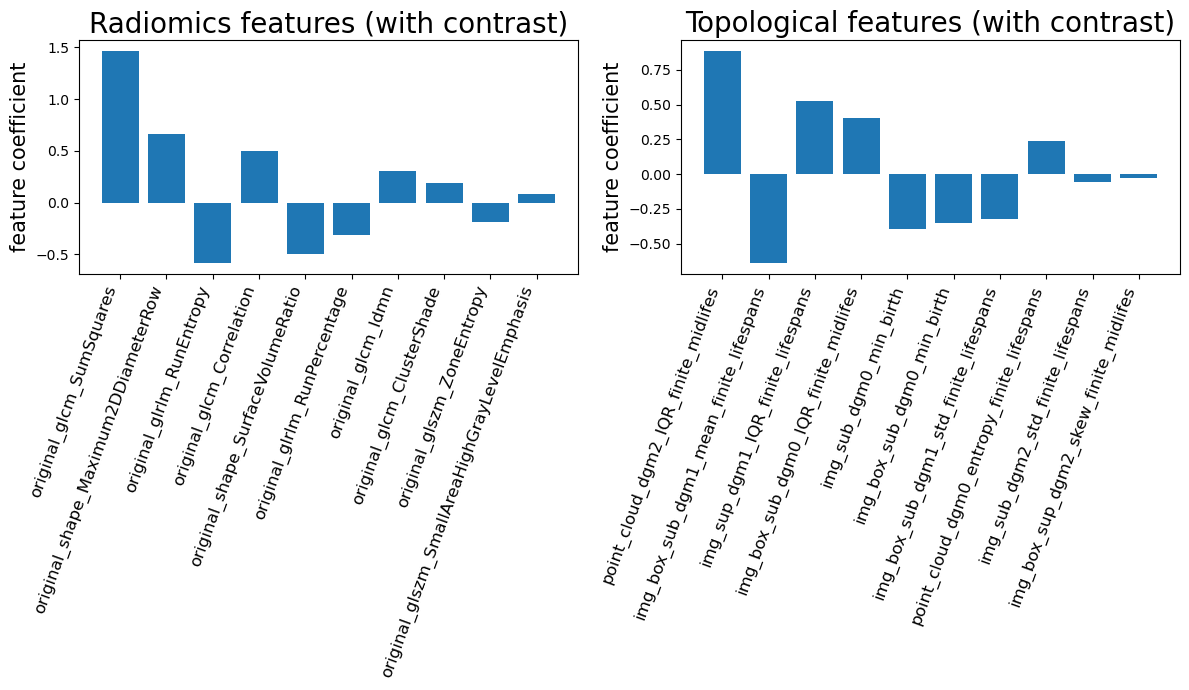

In [77]:
# Obtain feature importances for radiomics and topological features

model = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(n_features=10), 
                      LogisticRegression(random_state=42))

model.fit(X_dict["rad"].loc[I,], y)

selected_features_rad = list(X_dict["rad"].columns[model.steps[2][1].cols])
coeff_rad = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_rad))[::-1]
selected_features_rad = [selected_features_rad[idx] for idx in order]
coeff_rad = [coeff_rad[idx] for idx in order]

model.fit(X_dict["top"].loc[I,], y)

selected_features_top = list(X_dict["top"].columns[model.steps[2][1].cols])
coeff_top = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_top))[::-1]
selected_features_top = [selected_features_top[idx] for idx in order]
coeff_top = [coeff_top[idx] for idx in order]

# Print feature coefficients

print("\033[1mRadiomic feature coefficients \033[0m")
for i, c in enumerate(coeff_rad):
    print("Feature: {}, Coeff: {}".format(selected_features_rad[i], str(round(c, 2))))
print("\n")    
print("\033[1mTopological feature coefficients \033[0m")
for i, c in enumerate(coeff_top):
    print("Feature: {}, Coeff: {}".format(selected_features_top[i], str(round(c, 2))))

# Plot feature importances for radiomics and topological features

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
ax = axes.flatten()

ax[0].bar(selected_features_rad, coeff_rad)
ax[0].set_ylabel("feature coefficient", fontsize=15)
ax[0].set_xticks(range(len(selected_features_rad)))
ax[0].set_xticklabels(labels=selected_features_rad, rotation=70, ha="right", fontsize=12)
ax[0].set_title("Radiomics features (with contrast)", fontsize=20)

ax[1].bar(selected_features_top, coeff_top)
ax[1].set_ylabel("feature coefficient", fontsize=15)
ax[1].set_xticks(range(len(selected_features_top)))
ax[1].set_xticklabels(labels=selected_features_top, rotation=70, ha="right", fontsize=12)
ax[1].set_title("Topological features (with contrast)", fontsize=20)

fig.tight_layout()
plt.show()

We evaluate the various features for **'small cell lung cancer'** vs  **'non-small cell lung cancer'** class prediction.

Class distribution for current outcome (class0 = ['Small cell lung cancer'], class1 = ['Non-small cell lung cancer', 'Adenocarcinoma', 'Squamous cell carcinoma'])
0    19
1    21
Name: 0, dtype: int64


<AxesSubplot:>

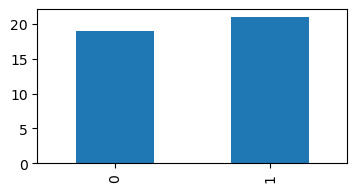

In [78]:
class0 = ["Small cell lung cancer"]
class1 = ["Non-small cell lung cancer", "Adenocarcinoma", "Squamous cell carcinoma"]
I, y = get_patients_with_outcome(contrast_indices, class0, class1)

print("Class distribution for current outcome (class0 = {}, class1 = {})".format(class0, class1))
value_counts = pd.DataFrame(y).iloc[:,0].value_counts().sort_index()
print(value_counts)
value_counts.plot(kind="bar", figsize=(4, 2))

In [431]:
results_summary = run_exps(X_dict={key:X_dict[key].loc[I,] for key in X_dict.keys()}, y=y, random_state=42)

results_summary.loc["mean",:] = results_summary.mean()
print("\nPerformance for tumor class prediction (class 0 = {}, class1 = {})".format(class0, class1))
results_summary.style.highlight_max(color="lightgreen", axis=1)

Calculating performances for model: LogReg
Calculating performances for model: RF
Calculating performances for model: KNN
Calculating performances for model: SVM
Calculating performances for model: GNB
Calculating performances for model: XGB

Performance for tumor class prediction (class 0 = ['Small cell lung cancer'], class1 = ['Non-small cell lung cancer', 'Adenocarcinoma', 'Squamous cell carcinoma'])


We investigate the feature importance for a better performing model.

Radiomic feature coefficients 
Feature: original_glszm_ZonePercentage, Coeff: 0.8
Feature: original_glrlm_ShortRunEmphasis, Coeff: 0.79
Feature: original_glszm_SmallAreaHighGrayLevelEmphasis, Coeff: 0.74
Feature: original_shape_Sphericity, Coeff: -0.72
Feature: original_glrlm_GrayLevelVariance, Coeff: -0.63
Feature: original_glcm_Imc1, Coeff: 0.56
Feature: original_glrlm_ShortRunLowGrayLevelEmphasis, Coeff: -0.3
Feature: original_glszm_LowGrayLevelZoneEmphasis, Coeff: -0.26
Feature: original_glrlm_GrayLevelNonUniformity, Coeff: -0.22
Feature: original_glcm_MCC, Coeff: -0.09


Topological feature coefficients 
Feature: img_sub_dgm0_Q1_finite_lifespans, Coeff: 0.97
Feature: img_sup_dgm2_Q3_finite_midlifes, Coeff: -0.74
Feature: img_sub_dgm1_no_finite_lifespans, Coeff: -0.67
Feature: img_sup_dgm1_kurtosis_finite_midlifes, Coeff: -0.55
Feature: img_box_sup_dgm0_Q1_finite_midlifes, Coeff: 0.42
Feature: img_box_sup_dgm0_Q3_finite_lifespans, Coeff: 0.36
Feature: point_cloud_dgm2_median_finite

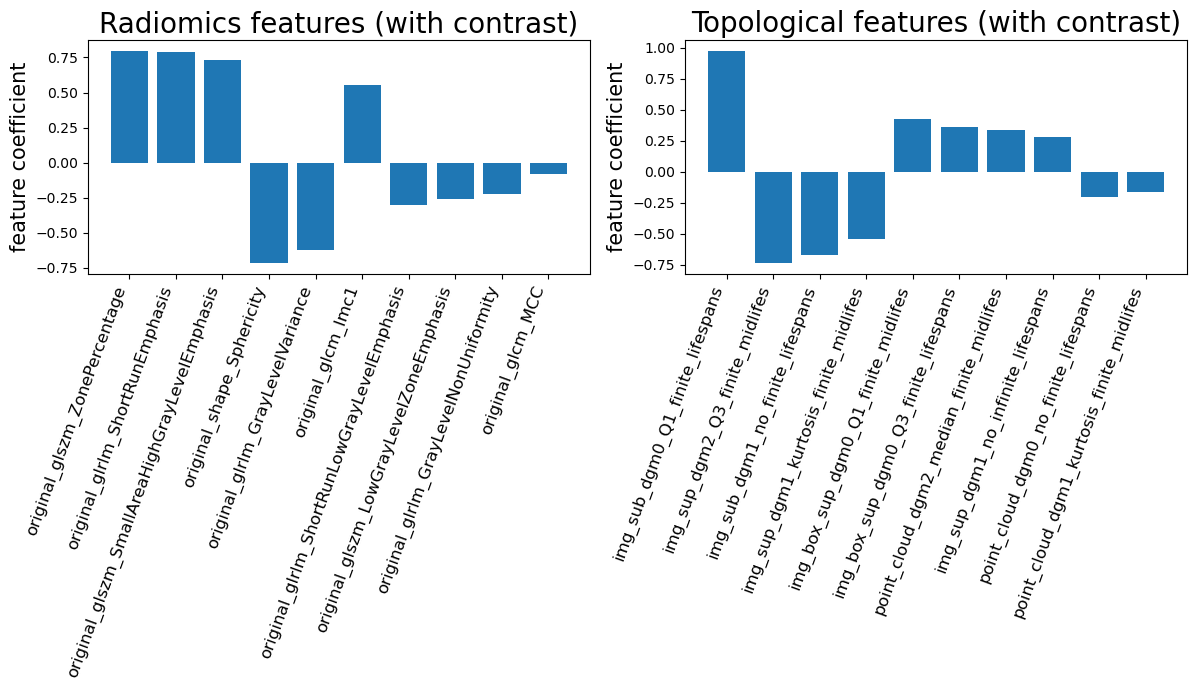

In [79]:
# Obtain feature importances for radiomics and topological features

model = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(n_features=10), 
                      LogisticRegression(random_state=42))

model.fit(X_dict["rad"].loc[I,], y)

selected_features_rad = list(X_dict["rad"].columns[model.steps[2][1].cols])
coeff_rad = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_rad))[::-1]
selected_features_rad = [selected_features_rad[idx] for idx in order]
coeff_rad = [coeff_rad[idx] for idx in order]

model.fit(X_dict["top"].loc[I,], y)

selected_features_top = list(X_dict["top"].columns[model.steps[2][1].cols])
coeff_top = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_top))[::-1]
selected_features_top = [selected_features_top[idx] for idx in order]
coeff_top = [coeff_top[idx] for idx in order]

# Print feature coefficients

print("\033[1mRadiomic feature coefficients \033[0m")
for i, c in enumerate(coeff_rad):
    print("Feature: {}, Coeff: {}".format(selected_features_rad[i], str(round(c, 2))))
print("\n")    
print("\033[1mTopological feature coefficients \033[0m")
for i, c in enumerate(coeff_top):
    print("Feature: {}, Coeff: {}".format(selected_features_top[i], str(round(c, 2))))
    
# Plot feature importances for radiomics and topological features

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
ax = axes.flatten()

ax[0].bar(selected_features_rad, coeff_rad)
ax[0].set_ylabel("feature coefficient", fontsize=15)
ax[0].set_xticks(range(len(selected_features_rad)))
ax[0].set_xticklabels(labels=selected_features_rad, rotation=70, ha="right", fontsize=12)
ax[0].set_title("Radiomics features (with contrast)", fontsize=20)

ax[1].bar(selected_features_top, coeff_top)
ax[1].set_ylabel("feature coefficient", fontsize=15)
ax[1].set_xticks(range(len(selected_features_top)))
ax[1].set_xticklabels(labels=selected_features_top, rotation=70, ha="right", fontsize=12)
ax[1].set_title("Topological features (with contrast)", fontsize=20)

fig.tight_layout()
plt.show()

We evaluate the various features for **'adenocarcinoma'** vs  **'squamous cell carcinoma'** class prediction.

Class distribution for current outcome (class0 = ['Adenocarcinoma'], class1 = ['Squamous cell carcinoma'])
0    15
1     6
Name: 0, dtype: int64


<AxesSubplot:>

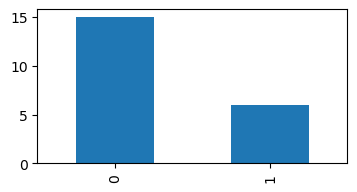

In [80]:
class0 = ["Adenocarcinoma"]
class1 = ["Squamous cell carcinoma"]
I, y = get_patients_with_outcome(contrast_indices, class0, class1)

print("Class distribution for current outcome (class0 = {}, class1 = {})".format(class0, class1))
value_counts = pd.DataFrame(y).iloc[:,0].value_counts().sort_index()
print(value_counts)
value_counts.plot(kind="bar", figsize=(4, 2))

In [398]:
results_summary = run_exps(X_dict={key:X_dict[key].loc[I,] for key in X_dict.keys()}, y=y, random_state=42)

results_summary.loc["mean",:] = results_summary.mean()
print("\nPerformance for tumor class prediction (class0 = {}, class1 = {})".format(class0, class1))
results_summary.style.highlight_max(color="lightgreen", axis=1)

Calculating performances for model: LogReg
Calculating performances for model: RF
Calculating performances for model: KNN
Calculating performances for model: SVM
Calculating performances for model: GNB
Calculating performances for model: XGB

Performance for tumor class prediction (class0 = ['Adenocarcinoma'], class1 = ['Squamous cell carcinoma'])


We investigate the feature importance for a better performing model.

Radiomic feature coefficients 
Feature: original_glcm_Imc2, Coeff: -0.9
Feature: original_firstorder_Skewness, Coeff: -0.7
Feature: original_shape_Sphericity, Coeff: -0.59
Feature: original_glcm_Correlation, Coeff: -0.44
Feature: original_glcm_MaximumProbability, Coeff: 0.38
Feature: original_glcm_SumAverage, Coeff: 0.38
Feature: original_glcm_JointAverage, Coeff: 0.38
Feature: original_firstorder_Kurtosis, Coeff: 0.31
Feature: original_glcm_Imc1, Coeff: 0.29
Feature: original_shape_SurfaceVolumeRatio, Coeff: -0.22


Topological feature coefficients 
Feature: img_sub_dgm0_std_finite_lifespans, Coeff: 0.92
Feature: img_sup_dgm1_skew_finite_midlifes, Coeff: 0.72
Feature: img_sup_dgm0_kurtosis_finite_midlifes, Coeff: 0.59
Feature: img_box_sub_dgm2_Q1_finite_lifespans, Coeff: 0.54
Feature: img_sup_dgm0_skew_finite_midlifes, Coeff: 0.47
Feature: img_box_sub_dgm0_Q1_finite_midlifes, Coeff: -0.42
Feature: point_cloud_dgm2_skew_finite_midlifes, Coeff: 0.29
Feature: img_sub_dgm0_IQR_finite_life

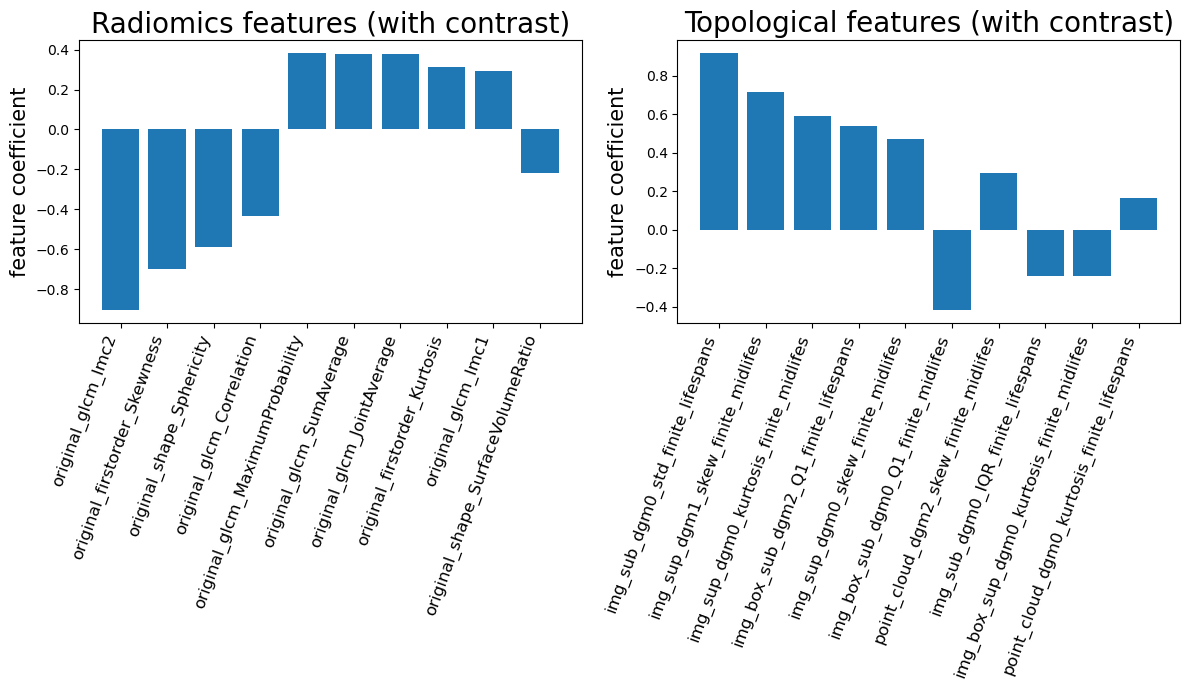

In [81]:
# Obtain feature importances for radiomics and topological features

model = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(n_features=10), 
                      LogisticRegression(random_state=42))

model.fit(X_dict["rad"].loc[I,], y)

selected_features_rad = list(X_dict["rad"].columns[model.steps[2][1].cols])
coeff_rad = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_rad))[::-1]
selected_features_rad = [selected_features_rad[idx] for idx in order]
coeff_rad = [coeff_rad[idx] for idx in order]

model.fit(X_dict["top"].loc[I,], y)

selected_features_top = list(X_dict["top"].columns[model.steps[2][1].cols])
coeff_top = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_top))[::-1]
selected_features_top = [selected_features_top[idx] for idx in order]
coeff_top = [coeff_top[idx] for idx in order]

# Print feature coefficients

print("\033[1mRadiomic feature coefficients \033[0m")
for i, c in enumerate(coeff_rad):
    print("Feature: {}, Coeff: {}".format(selected_features_rad[i], str(round(c, 2))))
print("\n")    
print("\033[1mTopological feature coefficients \033[0m")
for i, c in enumerate(coeff_top):
    print("Feature: {}, Coeff: {}".format(selected_features_top[i], str(round(c, 2))))
    
# Plot feature importances for radiomics and topological features

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
ax = axes.flatten()

ax[0].bar(selected_features_rad, coeff_rad)
ax[0].set_ylabel("feature coefficient", fontsize=15)
ax[0].set_xticks(range(len(selected_features_rad)))
ax[0].set_xticklabels(labels=selected_features_rad, rotation=70, ha="right", fontsize=12)
ax[0].set_title("Radiomics features (with contrast)", fontsize=20)

ax[1].bar(selected_features_top, coeff_top)
ax[1].set_ylabel("feature coefficient", fontsize=15)
ax[1].set_xticks(range(len(selected_features_top)))
ax[1].set_xticklabels(labels=selected_features_top, rotation=70, ha="right", fontsize=12)
ax[1].set_title("Topological features (with contrast)", fontsize=20)

fig.tight_layout()
plt.show()

### Images without contrast

We first construct the feature DataFrames for performance evaluation on the images **without contrast**. 

In [82]:
contrast = ["N"]
contrast_indices = [p for p in meta.index if meta.loc[p, "Contrast"] in contrast]

X_dict = {}

X_dict["rad"] = X_radiomics.copy().loc[contrast_indices,:]
X_dict["top"] = X_top.copy().loc[contrast_indices,:]
#for dgm_type in np.unique([k[:k.find("dgm") - 1] for k in X_top.columns]):
#for dgm_type in np.unique([k[:k.find("dgm") + 4] for k in X_top.columns]):
#    this_columns = [C for C in X_top.columns if C.startswith(dgm_type)]
#    X_dict[dgm_type] = X_top.copy().loc[contrast_indices, this_columns]

print("Number of patients with contrast {}: {}".format(contrast, str(len(contrast_indices))))

Number of patients with contrast ['N']: 125


We evaluate the various features for **'benign'** vs. **'non-benign'** class prediction.

Class distribution for current outcome (class0 = ['Benign'], class1 = ['Adenocarcinoma', 'Non-small cell lung cancer', 'Small cell lung cancer', 'Squamous cell carcinoma'])
0    75
1    50
Name: 0, dtype: int64


<AxesSubplot:>

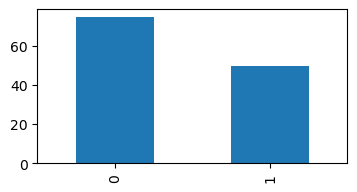

In [89]:
class0 = ["Benign"]
class1 = [c for c in all_classes if c not in class0]
I, y = get_patients_with_outcome(contrast_indices, class0, class1)

print("Class distribution for current outcome (class0 = {}, class1 = {})".format(class0, class1))
value_counts = pd.DataFrame(y).iloc[:,0].value_counts().sort_index()
print(value_counts)
value_counts.plot(kind="bar", figsize=(4, 2))

In [402]:
results_summary = run_exps(X_dict={key:X_dict[key].loc[I,] for key in X_dict.keys()}, y=y, random_state=42)

results_summary.loc["mean",:] = results_summary.mean()
print("\nPerformance for tumor class prediction (class 0 = {}, class1 = {})".format(class0, class1))
results_summary.style.highlight_max(color="lightgreen", axis=1)

Calculating performances for model: LogReg
Calculating performances for model: RF
Calculating performances for model: KNN
Calculating performances for model: SVM
Calculating performances for model: GNB
Calculating performances for model: XGB

Performance for tumor class prediction (class 0 = ['Benign'], class1 = ['Adenocarcinoma', 'Non-small cell lung cancer', 'Small cell lung cancer', 'Squamous cell carcinoma'])


We investigate the feature importance for a better performing model.

Radiomic feature coefficients 
Feature: original_glcm_ClusterProminence, Coeff: 1.39
Feature: original_glszm_SmallAreaEmphasis, Coeff: -0.86
Feature: original_glszm_ZoneVariance, Coeff: 0.69
Feature: original_shape_Flatness, Coeff: 0.64
Feature: original_firstorder_Kurtosis, Coeff: 0.48
Feature: original_shape_SurfaceVolumeRatio, Coeff: -0.46
Feature: original_firstorder_90Percentile, Coeff: -0.42
Feature: original_glrlm_RunLengthNonUniformity, Coeff: 0.34
Feature: original_firstorder_10Percentile, Coeff: 0.28
Feature: original_glcm_JointEnergy, Coeff: 0.02


Topological feature coefficients 
Feature: img_sup_dgm2_kurtosis_finite_midlifes, Coeff: 1.02
Feature: img_sup_dgm1_min_birth, Coeff: -0.88
Feature: img_sub_dgm0_IQR_finite_lifespans, Coeff: -0.88
Feature: img_sub_dgm2_IQR_finite_midlifes, Coeff: 0.71
Feature: img_sub_dgm2_Q1_finite_lifespans, Coeff: -0.5
Feature: point_cloud_dgm2_IQR_finite_midlifes, Coeff: 0.45
Feature: point_cloud_dgm2_median_finite_lifespans, Coeff: 0.34
Featu

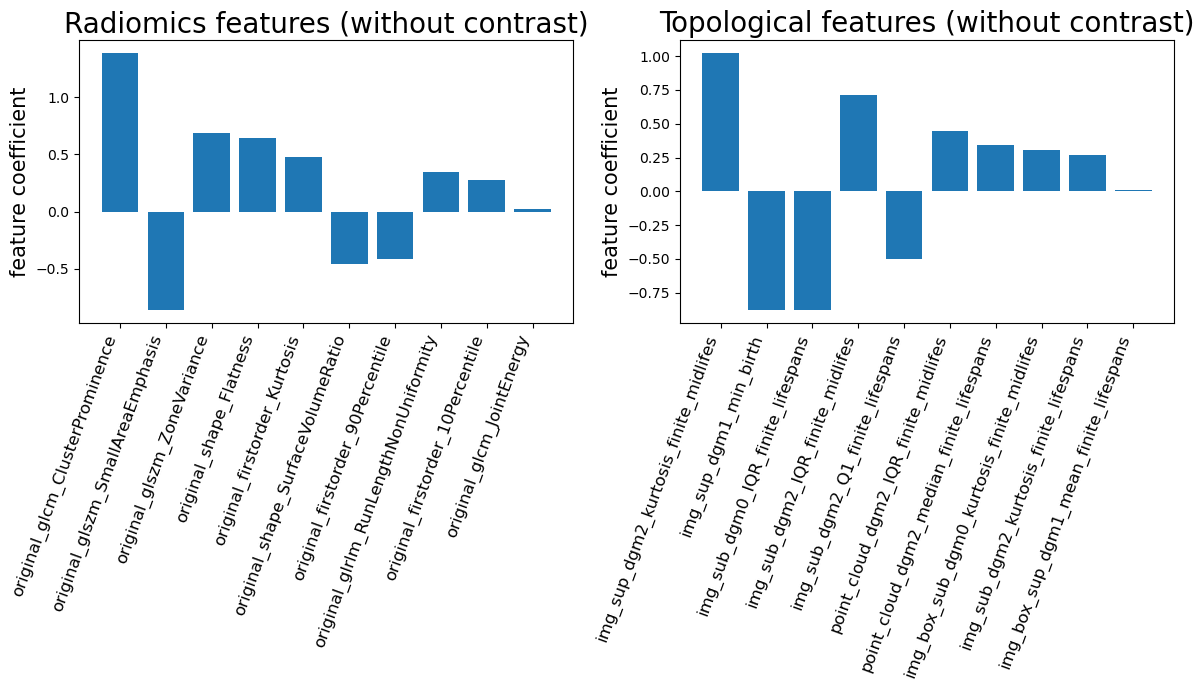

In [90]:
# Obtain feature importances for radiomics and topological features

model = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(n_features=10), 
                      LogisticRegression(random_state=42))

model.fit(X_dict["rad"].loc[I,], y)

selected_features_rad = list(X_dict["rad"].columns[model.steps[2][1].cols])
coeff_rad = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_rad))[::-1]
selected_features_rad = [selected_features_rad[idx] for idx in order]
coeff_rad = [coeff_rad[idx] for idx in order]

model.fit(X_dict["top"].loc[I,], y)

selected_features_top = list(X_dict["top"].columns[model.steps[2][1].cols])
coeff_top = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_top))[::-1]
selected_features_top = [selected_features_top[idx] for idx in order]
coeff_top = [coeff_top[idx] for idx in order]

# Print feature coefficients

print("\033[1mRadiomic feature coefficients \033[0m")
for i, c in enumerate(coeff_rad):
    print("Feature: {}, Coeff: {}".format(selected_features_rad[i], str(round(c, 2))))
print("\n")    
print("\033[1mTopological feature coefficients \033[0m")
for i, c in enumerate(coeff_top):
    print("Feature: {}, Coeff: {}".format(selected_features_top[i], str(round(c, 2))))

# Plot feature importances for radiomics and topological features

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
ax = axes.flatten()

ax[0].bar(selected_features_rad, coeff_rad)
ax[0].set_ylabel("feature coefficient", fontsize=15)
ax[0].set_xticks(range(len(selected_features_rad)))
ax[0].set_xticklabels(labels=selected_features_rad, rotation=70, ha="right", fontsize=12)
ax[0].set_title("Radiomics features (without contrast)", fontsize=20)

ax[1].bar(selected_features_top, coeff_top)
ax[1].set_ylabel("feature coefficient", fontsize=15)
ax[1].set_xticks(range(len(selected_features_top)))
ax[1].set_xticklabels(labels=selected_features_top, rotation=70, ha="right", fontsize=12)
ax[1].set_title("Topological features (without contrast)", fontsize=20)

fig.tight_layout()
plt.show()

We evaluate the various features for **'small cell lung cancer'** vs  **'non-small cell lung cancer'** class prediction.

Class distribution for current outcome (class0 = ['Small cell lung cancer'], class1 = ['Non-small cell lung cancer', 'Adenocarcinoma', 'Squamous cell carcinoma'])
0    12
1    38
Name: 0, dtype: int64


<AxesSubplot:>

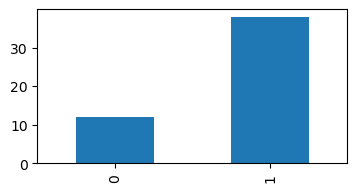

In [91]:
class0 = ["Small cell lung cancer"]
class1 = ["Non-small cell lung cancer", "Adenocarcinoma", "Squamous cell carcinoma"]
I, y = get_patients_with_outcome(contrast_indices, class0, class1)

print("Class distribution for current outcome (class0 = {}, class1 = {})".format(class0, class1))
value_counts = pd.DataFrame(y).iloc[:,0].value_counts().sort_index()
print(value_counts)
value_counts.plot(kind="bar", figsize=(4, 2))

In [405]:
results_summary = run_exps(X_dict={key:X_dict[key].loc[I,] for key in X_dict.keys()}, y=y, random_state=42)

results_summary.loc["mean",:] = results_summary.mean()
print("\nPerformance for tumor class prediction (class 0 = {}, class1 = {})".format(class0, class1))
results_summary.style.highlight_max(color="lightgreen", axis=1)

Calculating performances for model: LogReg
Calculating performances for model: RF
Calculating performances for model: KNN
Calculating performances for model: SVM
Calculating performances for model: GNB
Calculating performances for model: XGB

Performance for tumor class prediction (class 0 = ['Small cell lung cancer'], class1 = ['Non-small cell lung cancer', 'Adenocarcinoma', 'Squamous cell carcinoma'])


We investigate the feature importance for a better performing model.

Radiomic feature coefficients 
Feature: original_glcm_Imc1, Coeff: 1.56
Feature: original_glszm_SmallAreaEmphasis, Coeff: 0.87
Feature: original_glcm_Autocorrelation, Coeff: 0.82
Feature: original_glszm_ZonePercentage, Coeff: 0.81
Feature: original_glcm_Id, Coeff: -0.43
Feature: original_glcm_ClusterShade, Coeff: -0.37
Feature: original_glszm_SizeZoneNonUniformityNormalized, Coeff: 0.25
Feature: original_shape_Flatness, Coeff: 0.15
Feature: original_firstorder_Energy, Coeff: -0.11
Feature: original_glcm_MCC, Coeff: -0.02


Topological feature coefficients 
Feature: img_box_sup_dgm2_Q1_finite_lifespans, Coeff: -0.87
Feature: img_sup_dgm2_IQR_finite_midlifes, Coeff: -0.79
Feature: point_cloud_dgm2_median_finite_lifespans, Coeff: -0.75
Feature: img_sub_dgm0_kurtosis_finite_midlifes, Coeff: -0.75
Feature: point_cloud_dgm0_kurtosis_finite_lifespans, Coeff: -0.73
Feature: img_box_sub_dgm0_skew_finite_lifespans, Coeff: -0.48
Feature: img_sub_dgm2_std_finite_lifespans, Coeff: 0.38
Feature: poi

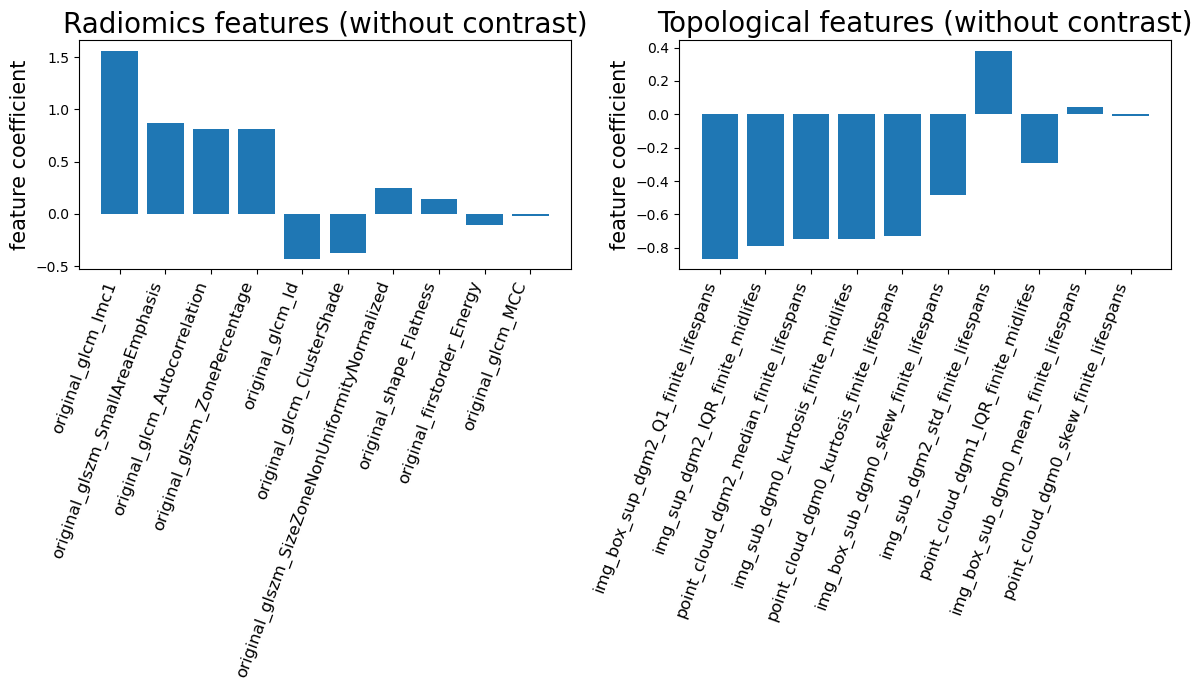

In [92]:
# Obtain feature importances for radiomics and topological features

model = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(n_features=10), 
                      LogisticRegression(random_state=42))

model.fit(X_dict["rad"].loc[I,], y)

selected_features_rad = list(X_dict["rad"].columns[model.steps[2][1].cols])
coeff_rad = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_rad))[::-1]
selected_features_rad = [selected_features_rad[idx] for idx in order]
coeff_rad = [coeff_rad[idx] for idx in order]

model.fit(X_dict["top"].loc[I,], y)

selected_features_top = list(X_dict["top"].columns[model.steps[2][1].cols])
coeff_top = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_top))[::-1]
selected_features_top = [selected_features_top[idx] for idx in order]
coeff_top = [coeff_top[idx] for idx in order]

# Print feature coefficients

print("\033[1mRadiomic feature coefficients \033[0m")
for i, c in enumerate(coeff_rad):
    print("Feature: {}, Coeff: {}".format(selected_features_rad[i], str(round(c, 2))))
print("\n")    
print("\033[1mTopological feature coefficients \033[0m")
for i, c in enumerate(coeff_top):
    print("Feature: {}, Coeff: {}".format(selected_features_top[i], str(round(c, 2))))

# Plot feature importances for radiomics and topological features

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
ax = axes.flatten()

ax[0].bar(selected_features_rad, coeff_rad)
ax[0].set_ylabel("feature coefficient", fontsize=15)
ax[0].set_xticks(range(len(selected_features_rad)))
ax[0].set_xticklabels(labels=selected_features_rad, rotation=70, ha="right", fontsize=12)
ax[0].set_title("Radiomics features (without contrast)", fontsize=20)

ax[1].bar(selected_features_top, coeff_top)
ax[1].set_ylabel("feature coefficient", fontsize=15)
ax[1].set_xticks(range(len(selected_features_top)))
ax[1].set_xticklabels(labels=selected_features_top, rotation=70, ha="right", fontsize=12)
ax[1].set_title("Topological features (without contrast)", fontsize=20)

fig.tight_layout()
plt.show()

We evaluate the various features for **'adenocarcinoma'** vs  **'squamous cell carcinoma'** class prediction.

Class distribution for current outcome (class0 = ['Adenocarcinoma'], class1 = ['Squamous cell carcinoma'])
0    21
1    15
Name: 0, dtype: int64


<AxesSubplot:>

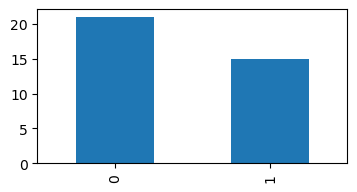

In [93]:
class0 = ["Adenocarcinoma"]
class1 = ["Squamous cell carcinoma"]
I, y = get_patients_with_outcome(contrast_indices, class0, class1)

print("Class distribution for current outcome (class0 = {}, class1 = {})".format(class0, class1))
value_counts = pd.DataFrame(y).iloc[:,0].value_counts().sort_index()
print(value_counts)
value_counts.plot(kind="bar", figsize=(4, 2))

In [408]:
results_summary = run_exps(X_dict={key:X_dict[key].loc[I,] for key in X_dict.keys()}, y=y, random_state=42)

results_summary.loc["mean",:] = results_summary.mean()
print("\nPerformance for tumor class prediction (class0 = {}, class1 = {})".format(class0, class1))
results_summary.style.highlight_max(color="lightgreen", axis=1)

Calculating performances for model: LogReg
Calculating performances for model: RF
Calculating performances for model: KNN
Calculating performances for model: SVM
Calculating performances for model: GNB
Calculating performances for model: XGB

Performance for tumor class prediction (class0 = ['Adenocarcinoma'], class1 = ['Squamous cell carcinoma'])


We investigate the feature importance for a better performing model.

Radiomic feature coefficients 
Feature: original_glcm_SumAverage, Coeff: 1.31
Feature: original_glcm_Correlation, Coeff: -1.04
Feature: original_shape_SurfaceVolumeRatio, Coeff: 0.67
Feature: original_glrlm_LongRunHighGrayLevelEmphasis, Coeff: -0.64
Feature: original_glcm_MaximumProbability, Coeff: 0.34
Feature: original_glcm_ClusterShade, Coeff: -0.32
Feature: original_glcm_MCC, Coeff: 0.26
Feature: original_firstorder_10Percentile, Coeff: 0.25
Feature: original_shape_Flatness, Coeff: -0.11
Feature: original_glszm_GrayLevelNonUniformityNormalized, Coeff: 0.04


Topological feature coefficients 
Feature: img_sub_dgm1_median_finite_midlifes, Coeff: 0.89
Feature: point_cloud_dgm1_skew_finite_midlifes, Coeff: 0.84
Feature: point_cloud_dgm0_entropy_finite_lifespans, Coeff: -0.7
Feature: img_sup_dgm2_kurtosis_finite_midlifes, Coeff: -0.7
Feature: img_sub_dgm2_std_finite_lifespans, Coeff: -0.63
Feature: img_sup_dgm2_skew_finite_lifespans, Coeff: -0.56
Feature: img_box_sub_dgm2_kurtosis_finit

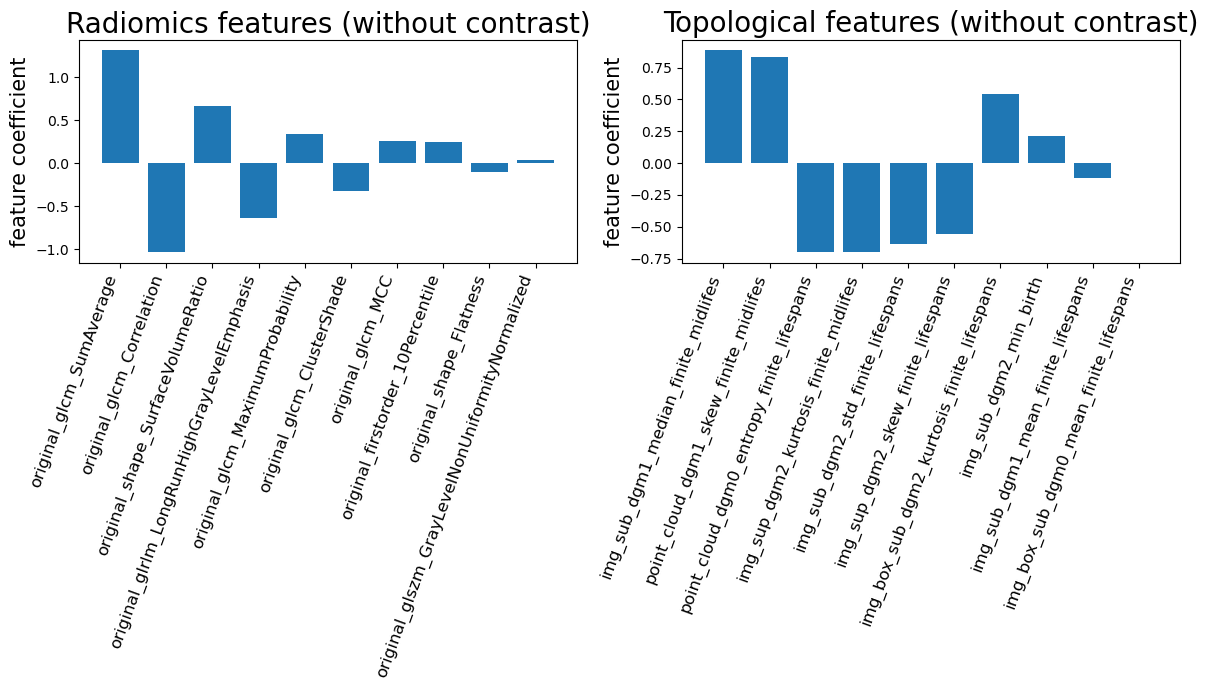

In [94]:
# Obtain feature importances for radiomics and topological features

model = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(n_features=10), 
                      LogisticRegression(random_state=42))

model.fit(X_dict["rad"].loc[I,], y)

selected_features_rad = list(X_dict["rad"].columns[model.steps[2][1].cols])
coeff_rad = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_rad))[::-1]
selected_features_rad = [selected_features_rad[idx] for idx in order]
coeff_rad = [coeff_rad[idx] for idx in order]

model.fit(X_dict["top"].loc[I,], y)

selected_features_top = list(X_dict["top"].columns[model.steps[2][1].cols])
coeff_top = model.steps[3][1].coef_[0]
order = np.argsort(np.abs(coeff_top))[::-1]
selected_features_top = [selected_features_top[idx] for idx in order]
coeff_top = [coeff_top[idx] for idx in order]

# Print feature coefficients

print("\033[1mRadiomic feature coefficients \033[0m")
for i, c in enumerate(coeff_rad):
    print("Feature: {}, Coeff: {}".format(selected_features_rad[i], str(round(c, 2))))
print("\n")    
print("\033[1mTopological feature coefficients \033[0m")
for i, c in enumerate(coeff_top):
    print("Feature: {}, Coeff: {}".format(selected_features_top[i], str(round(c, 2))))

# Plot feature importances for radiomics and topological features

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
ax = axes.flatten()

ax[0].bar(selected_features_rad, coeff_rad)
ax[0].set_ylabel("feature coefficient", fontsize=15)
ax[0].set_xticks(range(len(selected_features_rad)))
ax[0].set_xticklabels(labels=selected_features_rad, rotation=70, ha="right", fontsize=12)
ax[0].set_title("Radiomics features (without contrast)", fontsize=20)

ax[1].bar(selected_features_top, coeff_top)
ax[1].set_ylabel("feature coefficient", fontsize=15)
ax[1].set_xticks(range(len(selected_features_top)))
ax[1].set_xticklabels(labels=selected_features_top, rotation=70, ha="right", fontsize=12)
ax[1].set_title("Topological features (without contrast)", fontsize=20)

fig.tight_layout()
plt.show()

## Bottleneck Distance Analysis (Unsupervised)

We check how the outcome relates to the bottleneck distances between diagrams. We first define the patients and outcome to consider.

In [213]:
class0 = ["Small cell lung cancer"]
class1 = ["Non-small cell lung cancer", "Adenocarcinoma", "Squamous cell carcinoma"]
patients, y = get_patients_with_outcome(meta.index, class0, class1)

We calculate the bottleneck distances between the 0-dimensional point cloud persistence diagrams.

In [214]:
bndist0 = np.zeros([len(patients), len(patients)])

no_to_compute = bndist0.shape[0] * (bndist0.shape[0] - 1) / 2
no_computed = 0

for idx1 in range(bndist0.shape[0] - 1):
    for idx2 in range(idx1 + 1, bndist0.shape[0]):
        print("progress: " + str(round(100 * no_computed / no_to_compute, 2)).ljust(5, "0") + "%", end="\r")
        bndist0[idx1, idx2] = gudhi.bottleneck_distance(dgms["point_cloud"][patients[idx1]]["dgm0"], 
                                                        dgms["point_cloud"][patients[idx2]]["dgm0"])
        bndist0[idx2, idx1] = bndist0[idx1, idx2]
        no_computed += 1

print("progress: 100.0%", end="\r")

KeyboardInterrupt: 

We visualize how the bottleneck distances between the 0-dimensional diagrams relate to the TPS outcome

Text(0.5, 1.0, "0-dim. bottleneck distances (class 0 = ['Small cell lung cancer'])")

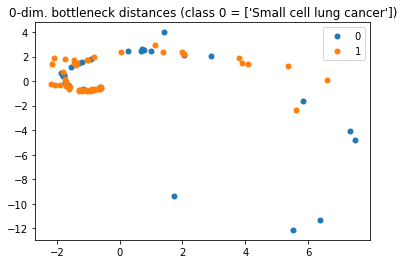

In [86]:
bnMDS0 = MDS(dissimilarity="precomputed", random_state=42).fit_transform(bndist0)
df_bnMDS0 = pd.concat([pd.DataFrame(bnMDS0), pd.DataFrame(y)], axis=1)
df_bnMDS0.columns = ["MDS1", "MDS2", "class"]

groups = df_bnMDS0.groupby("class")

fig, ax = plt.subplots(figsize=(6, 4))
for name, group in groups:
    ax.plot(group.MDS1, group.MDS2, marker="o", linestyle="", ms=5, label=name)
ax.legend()
ax.set_title("0-dim. bottleneck distances (class 0 = {})".format(str(class0)))

We calculate the bottleneck distances between the 1-dimensional point cloud persistence diagrams.

In [87]:
bndist1 = np.zeros([len(patients), len(patients)])

no_to_compute = bndist1.shape[0] * (bndist1.shape[0] - 1) / 2
no_computed = 0

for idx1 in range(bndist1.shape[0] - 1):
    for idx2 in range(idx1 + 1, bndist1.shape[0]):
        print("progress: " + str(round(100 * no_computed / no_to_compute, 2)).ljust(5, "0") + "%", end="\r")
        bndist1[idx1, idx2] = gudhi.bottleneck_distance(dgms["point_cloud"][patients[idx1]]["dgm1"], 
                                                        dgms["point_cloud"][patients[idx2]]["dgm1"])
        bndist1[idx2, idx1] = bndist1[idx1, idx2]
        no_computed += 1

print("progress: 100.0%", end="\r")

We visualize how the bottleneck distances between the 1-dimensional diagrams relate to the TPS outcome

Text(0.5, 1.0, "1-dim. bottleneck distances (class 0 = ['Small cell lung cancer'])")

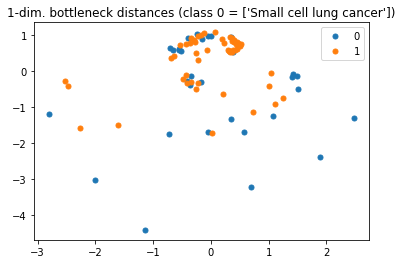

In [88]:
bnMDS1 = MDS(dissimilarity="precomputed", random_state=42).fit_transform(bndist1)
df_bnMDS1 = pd.concat([pd.DataFrame(bnMDS1), pd.DataFrame(y)], axis=1)
df_bnMDS1.columns = ["MDS1", "MDS2", "class"]

groups = df_bnMDS1.groupby("class")

fig, ax = plt.subplots(figsize=(6, 4))
for name, group in groups:
    ax.plot(group.MDS1, group.MDS2, marker="o", linestyle="", ms=5, label=name)
ax.legend()
ax.set_title("1-dim. bottleneck distances (class 0 = {})".format(str(class0)))

We calculate the bottleneck distances between the 2-dimensional point cloud persistence diagrams.

In [89]:
bndist2 = np.zeros([len(patients), len(patients)])

no_to_compute = bndist2.shape[0] * (bndist2.shape[0] - 1) / 2
no_computed = 0

for idx1 in range(bndist2.shape[0] - 1):
    for idx2 in range(idx1 + 1, bndist2.shape[0]):
        print("progress: " + str(round(100 * no_computed / no_to_compute, 2)).ljust(5, "0") + "%", end="\r")
        bndist2[idx1, idx2] = gudhi.bottleneck_distance(dgms["point_cloud"][patients[idx1]]["dgm2"], 
                                                        dgms["point_cloud"][patients[idx2]]["dgm2"])
        bndist2[idx2, idx1] = bndist2[idx1, idx2]
        no_computed += 1

print("progress: 100.0%", end="\r")

We visualize how the bottleneck distances between the 2-dimensional diagrams relate to the TPS outcome

Text(0.5, 1.0, "2-dim. bottleneck distances (class 0 = ['Small cell lung cancer'])")

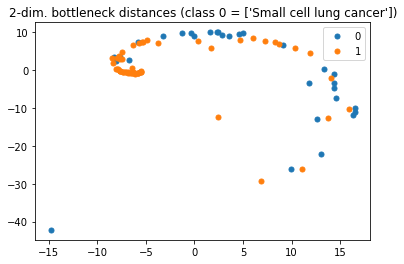

In [90]:
bnMDS2 = MDS(dissimilarity="precomputed", random_state=42).fit_transform(bndist2)
df_bnMDS2 = pd.concat([pd.DataFrame(bnMDS2), pd.DataFrame(y)], axis=1)
df_bnMDS2.columns = ["MDS1", "MDS2", "class"]

groups = df_bnMDS2.groupby("class")

fig, ax = plt.subplots(figsize=(6, 4))
for name, group in groups:
    ax.plot(group.MDS1, group.MDS2, marker="o", linestyle="", ms=5, label=name)
ax.legend()
ax.set_title("2-dim. bottleneck distances (class 0 = {})".format(str(class0)))